
# Spherepop Playground Notebook

A minimal executable toy model of **Spherepop**.

**Core ideas**
- Spheres = delayed irreversible events  
- `pop()` = evaluates once and records history  
- Identity = event provenance  
- Nested scopes = compositional structure  
- Geometry emerges from causal structure


## Imports and Core Structures

In [1]:
import uuid
from dataclasses import dataclass, field
from typing import Callable, Any, List, Tuple, Dict
import matplotlib.pyplot as plt


## Event, History, Sphere

In [2]:
@dataclass
class Event:
    eid: str
    label: str
    value: Any
    parents: Tuple[str, ...]

@dataclass
class History:
    events: Dict[str, Event] = field(default_factory=dict)

    def add(self, event: Event):
        self.events[event.eid] = event

    def lineage(self, eid: str) -> List[str]:
        seen = set()
        order = []
        def dfs(x):
            if x in seen:
                return
            seen.add(x)
            for p in self.events[x].parents:
                dfs(p)
            order.append(x)
        dfs(eid)
        return order

@dataclass
class Sphere:
    label: str
    thunk: Callable[['History'], Any]
    _eid: str = None

    def pop(self, history: History):
        if self._eid is not None:
            return history.events[self._eid].value, self._eid

        value, parents = self.thunk(history)
        eid = str(uuid.uuid4())
        history.add(Event(eid, self.label, value, parents))
        self._eid = eid
        return value, eid


## Primitive Constructors

In [3]:
def const(label, x):
    return Sphere(label, lambda h: (x, ()))

def add(label, a, b):
    def thunk(h):
        va, ea = a.pop(h)
        vb, eb = b.pop(h)
        return va + vb, (ea, eb)
    return Sphere(label, thunk)

def mul(label, a, b):
    def thunk(h):
        va, ea = a.pop(h)
        vb, eb = b.pop(h)
        return va * vb, (ea, eb)
    return Sphere(label, thunk)


## Example: (1 + 2) × 3

In [4]:
H = History()

s1 = const("one", 1)
s2 = const("two", 2)
s3 = const("three", 3)

expr = mul("mul", add("add", s1, s2), s3)
expr.pop(H)


(9, '933b6e03-15b9-40c3-9245-2ebfe3b635b8')

## Identity by History

In [5]:
H2 = History()
expr2 = mul("mul", add("add", const("one",1), const("two",2)), const("three",3))
expr2.pop(H2)

len(H.events), len(H2.events)


(5, 5)

## Event-History Geometry

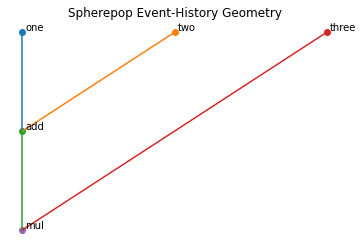

In [6]:
def depth(h, eid):
    e = h.events[eid]
    if not e.parents:
        return 0
    return 1 + max(depth(h, p) for p in e.parents)

nodes = list(H.events)
depths = {eid: depth(H, eid) for eid in nodes}

layers = {}
for eid, d in depths.items():
    layers.setdefault(d, []).append(eid)

pos = {}
for d, eids in layers.items():
    for i, eid in enumerate(eids):
        pos[eid] = (i, -d)

plt.figure()
for eid, e in H.events.items():
    x, y = pos[eid]
    plt.scatter([x], [y])
    plt.text(x + 0.02, y + 0.02, e.label)
    for p in e.parents:
        xp, yp = pos[p]
        plt.plot([xp, x], [yp, y])

plt.axis("off")
plt.title("Spherepop Event-History Geometry")
plt.show()


## Causal Depth Distribution

Event depth acts as *proper time* in Spherepop.
This histogram shows how many irreversible events exist at each causal depth.


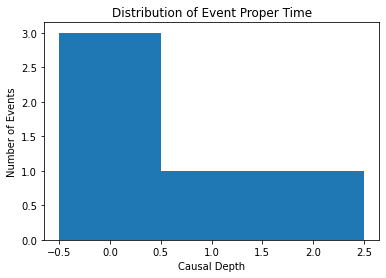

In [8]:
depths = [depth(H, eid) for eid in H.events]

plt.figure()
plt.hist(depths, bins=range(max(depths)+2), align="left")
plt.xlabel("Causal Depth")
plt.ylabel("Number of Events")
plt.title("Distribution of Event Proper Time")
plt.show()

## Causal Centrality of Events

Some events are structurally more important than others:
many later events depend on them, directly or indirectly.

This plot shows *causal centrality* — how much future history flows through each event.


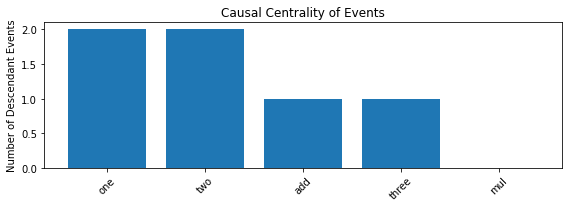

In [9]:
# Compute transitive fan-out (causal centrality)

from functools import lru_cache

@lru_cache(None)
def descendants(eid):
    ds = set()
    for e in H.events.values():
        if eid in e.parents:
            ds.add(e.eid)
            ds |= descendants(e.eid)
    return ds

centrality = {eid: len(descendants(eid)) for eid in H.events}

labels = [H.events[e].label for e in centrality]
scores = list(centrality.values())

plt.figure(figsize=(8,3))
plt.bar(range(len(scores)), scores)
plt.xticks(range(len(labels)), labels, rotation=45)
plt.ylabel("Number of Descendant Events")
plt.title("Causal Centrality of Events")
plt.tight_layout()
plt.show()


## Radial Embedding of the Event Partial Order

This visualization embeds the event history into a two-dimensional plane by
interpreting causal depth as a radial coordinate. Events with greater causal
depth are placed farther from the origin, while angular position is assigned
recursively according to parent–child relations.

The resulting embedding provides a geometric representation of the partial
order induced by irreversible event construction. Branching structures appear
as angular bifurcations, while shared ancestry produces clustered radial
features.

No metric interpretation is assumed; distances are illustrative rather than
physical. The purpose of the embedding is to reveal large-scale causal
structure and branching topology.


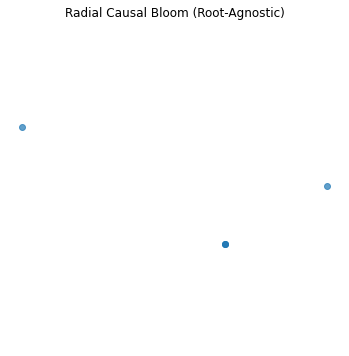

In [11]:
import math
import random

# find causal roots automatically
roots = [eid for eid, e in H.events.items() if not e.parents]

angles = {}

def assign_angle(eid, theta):
    angles[eid] = theta
    children = [e.eid for e in H.events.values() if eid in e.parents]
    if not children:
        return
    spread = math.pi / max(1, len(children))
    for i, c in enumerate(children):
        assign_angle(c, theta + (i - len(children)/2)*spread)

# spread roots evenly around circle
for i, r in enumerate(roots):
    assign_angle(r, 2 * math.pi * i / max(1, len(roots)))

xs, ys = [], []
for eid in H.events:
    r = depth(H, eid)
    theta = angles.get(eid, random.uniform(-math.pi, math.pi))
    xs.append(r * math.cos(theta))
    ys.append(r * math.sin(theta))

plt.figure(figsize=(6,6))
plt.scatter(xs, ys, alpha=0.7)
plt.axis("equal")
plt.axis("off")
plt.title("Radial Causal Bloom (Root-Agnostic)")
plt.show()


## Lineage Trajectories in Event History

This visualization depicts multiple event lineages simultaneously. Each
trajectory corresponds to the causal ancestry of a selected event, ordered by
irreversible evaluation.

The vertical axis represents causal depth (interpretable as proper time),
while horizontal displacement introduces a stable jitter to distinguish
distinct lineages. Overlapping or braided trajectories indicate shared
ancestry or reuse of intermediate events.

This representation emphasizes the multiplicity of valid causal histories
within a single event ledger and highlights the relational nature of temporal
structure in the system.


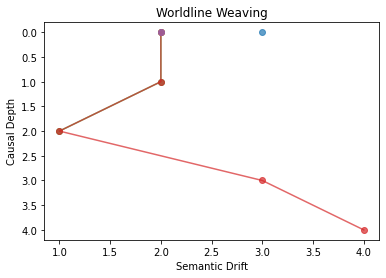

In [12]:
import random

plt.figure(figsize=(6,4))

for eid in random.sample(list(H.events), min(5, len(H.events))):
    line = H.lineage(eid)
    ys = list(range(len(line)))
    xs = [hash(e) % 10 for e in line]  # stable jitter
    plt.plot(xs, ys, marker="o", alpha=0.7)

plt.gca().invert_yaxis()
plt.xlabel("Semantic Drift")
plt.ylabel("Causal Depth")
plt.title("Worldline Weaving")
plt.show()


## Spiral Embedding of Causal Accumulation

In this embedding, events are ordered by causal depth and mapped onto a spiral
curve in the plane. Incremental angular displacement is modulated by event
fan-in, producing increased curvature for events that integrate multiple
parents.

The spiral geometry provides a compact visualization of cumulative causal
complexity. Regions of high curvature correspond to semantic integration or
merging, while extended low-curvature segments indicate largely linear
development.

This embedding is topological rather than dynamical; it does not assume an
underlying spatial substrate.


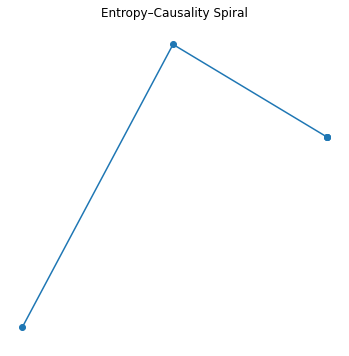

In [14]:
theta = 0
xs, ys = [], []

for eid in sorted(H.events, key=lambda e: depth(H, e)):
    r = depth(H, eid)
    curvature = len(H.events[eid].parents)
    theta += 0.5 + 0.3 * curvature
    xs.append(r * math.cos(theta))
    ys.append(r * math.sin(theta))

plt.figure(figsize=(6,6))
plt.plot(xs, ys, marker="o")
plt.axis("equal")
plt.axis("off")
plt.title("Entropy–Causality Spiral")
plt.show()


## Relational Embedding of Event Connectivity

This visualization represents events as points in a non-metric plane with
randomized coordinates, while causal relations are drawn as edges between
events and their parents.

The absence of a fixed coordinate system emphasizes relational structure over
spatial interpretation. Clusters arise from shared dependencies, while sparse
regions indicate loosely connected event subsets.

This view is intended to make connectivity and dependency patterns visually
salient without imposing geometric assumptions.


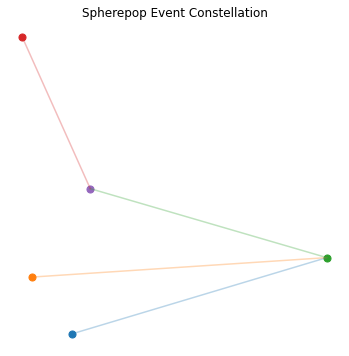

In [15]:
positions = {
    eid: (random.gauss(0,1), random.gauss(0,1))
    for eid in H.events
}

plt.figure(figsize=(6,6))

for eid, e in H.events.items():
    x, y = positions[eid]
    plt.scatter(x, y, s=50)
    for p in e.parents:
        xp, yp = positions[p]
        plt.plot([xp, x], [yp, y], alpha=0.3)

plt.axis("off")
plt.title("Spherepop Event Constellation")
plt.show()


## Voronoi Partition of Event Influence

This visualization constructs a Voronoi diagram over an abstract embedding of
events. Each event is treated as a generator point, and the plane is partitioned
into regions consisting of points closer to that event than to any other.

The resulting tessellation provides a geometric representation of *domains of
influence* within the event history. Events with dense local connectivity tend
to dominate larger regions, while events in crowded causal neighborhoods occupy
smaller cells.

The embedding is representational rather than physical. The Voronoi structure
is used to expose relational proximity and clustering without assuming a
pre-existing spatial metric.


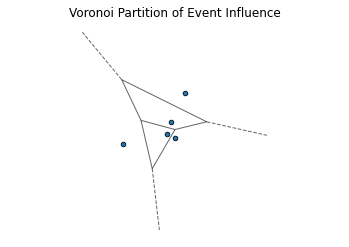

In [16]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.spatial import Voronoi, voronoi_plot_2d
import random

# assign stable pseudo-random positions to events
rng = np.random.default_rng(42)
event_ids = list(H.events.keys())

points = rng.normal(size=(len(event_ids), 2))

# compute Voronoi diagram
vor = Voronoi(points)

# plot
fig = voronoi_plot_2d(vor, show_vertices=False, line_alpha=0.6)
plt.scatter(points[:,0], points[:,1], c="black", s=20)

plt.title("Voronoi Partition of Event Influence")
plt.axis("equal")
plt.axis("off")
plt.show()


## Voronoi Partition of Event Influence

This visualization constructs a Voronoi tessellation over an abstract embedding
of events. Each event acts as a generator point, and the plane is partitioned
into regions whose points are closer to that event than to any other.

The resulting cells can be interpreted as domains of influence associated with
individual events. Events embedded in sparse regions of the causal structure
tend to occupy larger cells, while events embedded in dense neighborhoods are
associated with smaller regions.

The embedding is representational rather than physical and is intended to expose
relational proximity rather than metric distance.


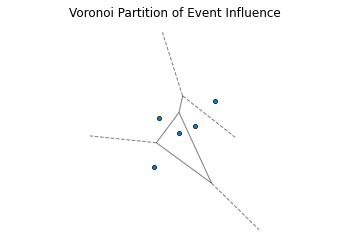

In [17]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.spatial import Voronoi, voronoi_plot_2d

rng = np.random.default_rng(0)
event_ids = list(H.events.keys())
points = rng.normal(size=(len(event_ids), 2))

vor = Voronoi(points)

fig = voronoi_plot_2d(vor, show_vertices=False, line_alpha=0.5)
plt.scatter(points[:,0], points[:,1], s=15, c="black")
plt.title("Voronoi Partition of Event Influence")
plt.axis("equal")
plt.axis("off")
plt.show()


## Delaunay Dual Graph of Event Adjacency

The Delaunay triangulation is the planar dual of the Voronoi tessellation.
Edges in the triangulation connect events whose Voronoi cells share a boundary.

This graph provides an explicit representation of local adjacency relations
between events. It exposes neighborhood structure without reference to causal
direction or temporal ordering.

Together with the Voronoi partition, this forms a topological description of
event proximity.


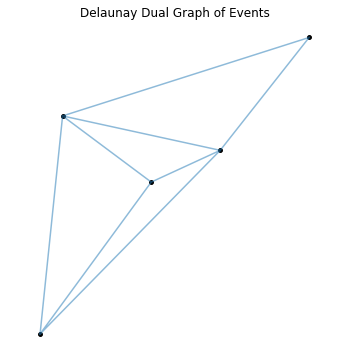

In [18]:
from scipy.spatial import Delaunay

tri = Delaunay(points)

plt.figure(figsize=(6,6))
plt.triplot(points[:,0], points[:,1], tri.simplices, alpha=0.5)
plt.scatter(points[:,0], points[:,1], c="black", s=15)
plt.title("Delaunay Dual Graph of Events")
plt.axis("equal")
plt.axis("off")
plt.show()


## Causal-Weighted Voronoi Tessellation

This variant modifies the Voronoi construction by weighting distance according
to causal depth. Events with greater causal depth exert a stronger influence on
the partitioning of space.

The resulting tessellation reflects accumulated causal history rather than
uniform geometric proximity. Regions associated with deep events expand, while
regions associated with shallow events contract.

This can be interpreted as a geometric analogue of causal accumulation.


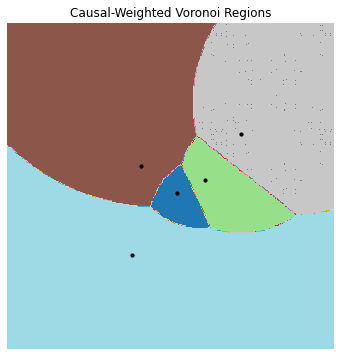

In [19]:
res = 300
x = np.linspace(-3, 3, res)
y = np.linspace(-3, 3, res)
xx, yy = np.meshgrid(x, y)
grid = np.stack([xx, yy], axis=-1)

depths = np.array([depth(H, eid) for eid in event_ids]) + 1.0

distances = np.sum((grid[...,None,:] - points)**2, axis=-1)
weighted = distances / depths

regions = np.argmin(weighted, axis=-1)

plt.figure(figsize=(6,6))
plt.imshow(regions, extent=(-3,3,-3,3), origin="lower", cmap="tab20")
plt.scatter(points[:,0], points[:,1], c="black", s=10)
plt.title("Causal-Weighted Voronoi Regions")
plt.axis("off")
plt.show()


## Entropy Basin Cellular Foam

In this visualization, Voronoi-like regions are constructed using entropy as an
effective potential. Events with higher associated entropy attract larger
regions of influence.

The resulting cellular pattern resembles a foam or basin structure and provides
an intuitive geometric depiction of entropy gradients in the event history.

This representation is qualitative and intended to support structural
interpretation rather than quantitative measurement.


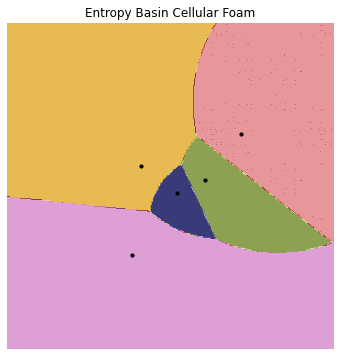

In [20]:
# assign synthetic entropy if none exists
def event_entropy(e):
    return getattr(e.value, "S", len(e.parents) + 1)

entropies = np.array([event_entropy(H.events[eid]) for eid in event_ids])

distances = np.sum((grid[...,None,:] - points)**2, axis=-1)
entropy_weighted = distances / (1.0 + entropies)

regions = np.argmin(entropy_weighted, axis=-1)

plt.figure(figsize=(6,6))
plt.imshow(regions, extent=(-3,3,-3,3), origin="lower", cmap="tab20b")
plt.scatter(points[:,0], points[:,1], c="black", s=10)
plt.title("Entropy Basin Cellular Foam")
plt.axis("off")
plt.show()
